## Preprocessing

In [25]:
import pandas as pd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt 

In [11]:
df = pd.read_csv('wikigraph_reduced.csv', delimiter = '\t')

In [12]:
df

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222
...,...,...,...
483089,28511768,1791481,1060990
483090,28511769,1791481,1061382
483091,28511771,1791481,1110380
483092,28511772,1791482,80740


In [13]:
df1 = pd.read_csv(r'wiki-topcats-categories.txt', sep=" ",error_bad_lines=False,)

b'Skipping line 82: expected 544 fields, saw 590\nSkipping line 92: expected 544 fields, saw 547\nSkipping line 129: expected 544 fields, saw 595\nSkipping line 160: expected 544 fields, saw 588\nSkipping line 220: expected 544 fields, saw 992\nSkipping line 232: expected 544 fields, saw 611\nSkipping line 233: expected 544 fields, saw 998\nSkipping line 234: expected 544 fields, saw 978\nSkipping line 235: expected 544 fields, saw 1313\nSkipping line 242: expected 544 fields, saw 549\nSkipping line 298: expected 544 fields, saw 591\nSkipping line 306: expected 544 fields, saw 936\nSkipping line 308: expected 544 fields, saw 838\nSkipping line 391: expected 544 fields, saw 614\nSkipping line 490: expected 544 fields, saw 692\nSkipping line 504: expected 544 fields, saw 772\nSkipping line 533: expected 544 fields, saw 1249\nSkipping line 583: expected 544 fields, saw 916\nSkipping line 601: expected 544 fields, saw 1041\nSkipping line 646: expected 544 fields, saw 675\nSkipping line 656

b'Skipping line 8697: expected 694 fields, saw 1004\nSkipping line 8705: expected 694 fields, saw 834\nSkipping line 8727: expected 694 fields, saw 768\nSkipping line 8733: expected 694 fields, saw 13705\nSkipping line 8734: expected 694 fields, saw 5702\nSkipping line 8740: expected 694 fields, saw 1129\nSkipping line 8806: expected 694 fields, saw 786\nSkipping line 8846: expected 694 fields, saw 726\nSkipping line 8869: expected 694 fields, saw 928\nSkipping line 8936: expected 694 fields, saw 2229\nSkipping line 8939: expected 694 fields, saw 2556\nSkipping line 8963: expected 694 fields, saw 1938\nSkipping line 8984: expected 694 fields, saw 1073\nSkipping line 8991: expected 694 fields, saw 1815\nSkipping line 8992: expected 694 fields, saw 1479\nSkipping line 9025: expected 694 fields, saw 1843\nSkipping line 9029: expected 694 fields, saw 906\nSkipping line 9049: expected 694 fields, saw 1291\nSkipping line 9058: expected 694 fields, saw 873\nSkipping line 9094: expected 694 fi

b'Skipping line 16313: expected 694 fields, saw 945\nSkipping line 16333: expected 694 fields, saw 706\nSkipping line 16447: expected 694 fields, saw 900\nSkipping line 16463: expected 694 fields, saw 788\nSkipping line 16481: expected 694 fields, saw 757\nSkipping line 16632: expected 694 fields, saw 1224\nSkipping line 16641: expected 694 fields, saw 1165\nSkipping line 16649: expected 694 fields, saw 1407\nSkipping line 16657: expected 694 fields, saw 932\nSkipping line 16782: expected 694 fields, saw 802\nSkipping line 16803: expected 694 fields, saw 757\nSkipping line 16814: expected 694 fields, saw 1030\nSkipping line 16815: expected 694 fields, saw 1147\nSkipping line 16816: expected 694 fields, saw 835\nSkipping line 16817: expected 694 fields, saw 706\nSkipping line 16844: expected 694 fields, saw 1434\nSkipping line 16906: expected 694 fields, saw 708\nSkipping line 16911: expected 694 fields, saw 918\nSkipping line 16916: expected 694 fields, saw 914\nSkipping line 16917: ex

In [14]:
df1.head()

,Category:Buprestoidea;,301,302,303,304,305,306,307,308,309,...,834,835,836,837,838,839,840,841,842,1791374
0,Category:People_from_Worcester;,1056.0,1057.0,1058.0,1059.0,1060.0,60971.0,76515.0,76871.0,78094.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Category:Skin_conditions_resulting_from_physic...,971.0,973.0,1166.0,1167.0,1168.0,1169.0,1170.0,1171.0,1172.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Category:Visual_kei_bands;,1297.0,1300.0,1311.0,1312.0,1313.0,1314.0,1315.0,1316.0,1319.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Category:Japanese_rock_music_groups;,1297.0,1300.0,1313.0,1314.0,1315.0,1316.0,1319.0,1320.0,1322.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Category:Laboulbeniomycetes;,1941.0,1942.0,1943.0,1944.0,1945.0,1947.0,1948.0,1949.0,1950.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df2 = pd.read_csv(r'wiki-topcats-page-names.txt',header=0, sep=" ",
                  error_bad_lines=False, nrows = 10000,
                 names = ['index', 'name1', 'name2'])

b'Skipping line 4: expected 3 fields, saw 4\nSkipping line 5: expected 3 fields, saw 4\nSkipping line 6: expected 3 fields, saw 4\nSkipping line 7: expected 3 fields, saw 5\nSkipping line 9: expected 3 fields, saw 4\nSkipping line 12: expected 3 fields, saw 4\nSkipping line 13: expected 3 fields, saw 4\nSkipping line 16: expected 3 fields, saw 4\nSkipping line 17: expected 3 fields, saw 4\nSkipping line 19: expected 3 fields, saw 4\nSkipping line 25: expected 3 fields, saw 4\nSkipping line 26: expected 3 fields, saw 4\nSkipping line 27: expected 3 fields, saw 4\nSkipping line 28: expected 3 fields, saw 4\nSkipping line 29: expected 3 fields, saw 4\nSkipping line 30: expected 3 fields, saw 4\nSkipping line 31: expected 3 fields, saw 4\nSkipping line 33: expected 3 fields, saw 4\nSkipping line 34: expected 3 fields, saw 4\nSkipping line 35: expected 3 fields, saw 4\nSkipping line 36: expected 3 fields, saw 4\nSkipping line 37: expected 3 fields, saw 4\nSkipping line 38: expected 3 fields

In [20]:
col_1 = []
col_2 = []
f=  open (r'wiki-topcats-page-names.txt', 'r')
count = 0
for file in tqdm(f):
    z = file.split(' ',maxsplit = 1)
    col_1.append(z[0])
    col_2.append(z[1].replace('\n', ''))

1791489it [00:01, 1199008.29it/s]


In [21]:
page_names = pd.DataFrame()
page_names['index'] = col_1
page_names['name'] =  col_2

In [22]:
page_names.to_csv('page_names.csv')

In [23]:
page_names

,index,name
0,0,Chiasmal syndrome
1,1,Kleroterion
2,2,Pinakion
3,3,LyndonHochschildSerre spectral sequence
4,4,Zariski's main theorem
...,...,...
1791484,1791484,Noadiah Russell (Yale founder)
1791485,1791485,Cornus officinalis
1791486,1791486,Peter Grummitt
1791487,1791487,Baron Estcourt


In [24]:
count = 0
from tqdm import tqdm
with open(r'wiki-topcats-page-names.txt' ,'r') as f:
    for line in tqdm(f):
        count+=1

1791489it [00:00, 2529971.06it/s]


In [26]:
G = nx.DiGraph()
for i in tqdm(range(len(df[:10]))):
    G.add_edge(df.loc[i][0], df.loc[i][1])

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3340.48it/s]


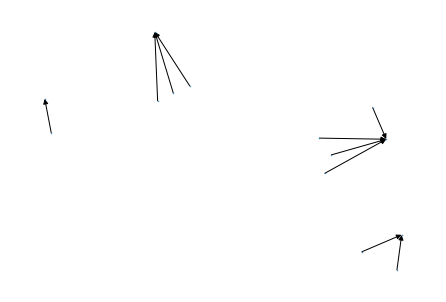

In [27]:
nx.draw(G, node_size=0.2 )

In [36]:
# Number of articles
len(G.nodes)

14

In [37]:
# number of edges/hyperlinks 
len(G.edges)

10

In [39]:
dict(G.degree)

{796: 1,
 95: 1,
 909: 1,
 108: 3,
 910: 1,
 911: 1,
 1141: 1,
 134: 4,
 1143: 1,
 1146: 1,
 1147: 1,
 1309: 1,
 153: 2,
 1311: 1}

In [31]:
import numpy as np
# Compute the average number of links in an arbitrary page
np.mean(list(dict(G.degree).values()))

1.4285714285714286

In [33]:
# According to the density the graph is a sparse graph.
n = len(G.nodes)
m = len(G.edges)
density = m/(n*(n-1))
density

0.054945054945054944

(array([11.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

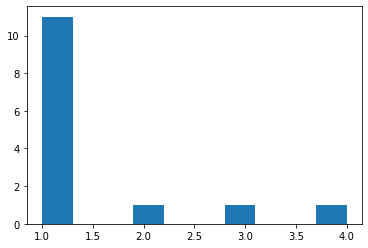

In [34]:
import matplotlib.pyplot as plt
plt.hist(list(dict(G.degree).values()))